In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
trips = pq.read_table("trips09.parquet") 
trips = trips.to_pandas()
import geopandas as gpd
geo = gpd.read_file("geo.shp")

In [2]:
cs = gpd.read_file('cs_geo.shp')
cs.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATION NA  1152 non-null   object  
 1   TYPE OF CH  1152 non-null   object  
 2   NO. OF PLU  1152 non-null   int64   
 3   BOROUGH     1152 non-null   object  
 4   PUBLIC CHA  24 non-null     object  
 5   LATITUDE    1152 non-null   float64 
 6   LONGITUDE   1152 non-null   float64 
 7   geometry    1152 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(4)
memory usage: 72.1+ KB


In [3]:
df = trips[~trips['DOLocationID'].isin([265]) & ~trips['PULocationID'].isin([265])]

In [4]:
geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   longitude   263 non-null    float64 
 7   latitude    263 non-null    float64 
 8   geometry    263 non-null    geometry
dtypes: float64(4), geometry(1), int32(2), object(2)
memory usage: 16.6+ KB


In [5]:
# Coverage Radius for Charging Stations
from shapely.geometry import Point

# Define the coverage radius in miles and convert to degrees (~1 mile ≈ 0.0145 degrees)
coverage_radius_miles = 2
coverage_radius_degrees = coverage_radius_miles / 69 # Approximate conversion

# Create a coverage buffer around each station
cs['coverage_area'] = cs.geometry.buffer(coverage_radius_degrees)

# Check if each zone is within a charging station's buffer
coverage_matrix = {}
for i, zone in geo.iterrows():
    coverage_matrix[i] = {}
    for j, station in cs.iterrows():
        coverage_matrix[i][j] = int(zone.geometry.centroid.within(station['coverage_area']))

coverage_ = pd.DataFrame(coverage_matrix).T 

C:\Users\r-cet\AppData\Local\Temp\ipykernel_14548\48712145.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cs['coverage_area'] = cs.geometry.buffer(coverage_radius_degrees)


In [6]:
zones_covered = (coverage_.sum(axis=1) > 0).sum()
total_zones = coverage_.shape[0]
coverage_percentage = (zones_covered / total_zones) * 100
print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 97.72%


In [7]:
print(coverage_.sum(axis=1))  # This will show the number of stations covering each zone
print((coverage_.sum(axis=1) > 0).sum())  # This will show the number of covered zones
print(f"Total Zones: {coverage_.shape[0]}")  # This will print the total number of zones

0       0
1       0
2      20
3      88
4      15
       ..
258    18
259    72
260    71
261    64
262    45
Length: 263, dtype: int64
257
Total Zones: 263


In [8]:
from geopy.distance import geodesic

def is_covered(zone_coords, station_coords, radius_miles):
    return geodesic(zone_coords, station_coords).miles <= radius_miles

coverage_Matrix = {}

# Check coverage for each zone
for i, zone in geo.iterrows():
    zone_coords = (zone['latitude'], zone['longitude'])
    coverage_Matrix[i] = {}
    for j, station in cs.iterrows():
        station_coords = (station['LATITUDE'], station['LONGITUDE'])
        if is_covered(zone_coords, station_coords, radius_miles=2):
            coverage_matrix[i][j] = 1
        else:
            coverage_matrix[i][j] = 0

coverage__ = pd.DataFrame(coverage_matrix).T
coverage__

,0,1,2,3,4,5,6,7,8,9,...,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
259,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,0,0,0
260,0,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
261,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
zones_covered = (coverage__.sum(axis=1) > 0).sum()
total_zones = coverage__.shape[0]
coverage_percentage = (zones_covered / total_zones) * 100
print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 98.86%


C:\Users\r-cet\AppData\Local\Temp\ipykernel_25152\1346362554.py:35: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


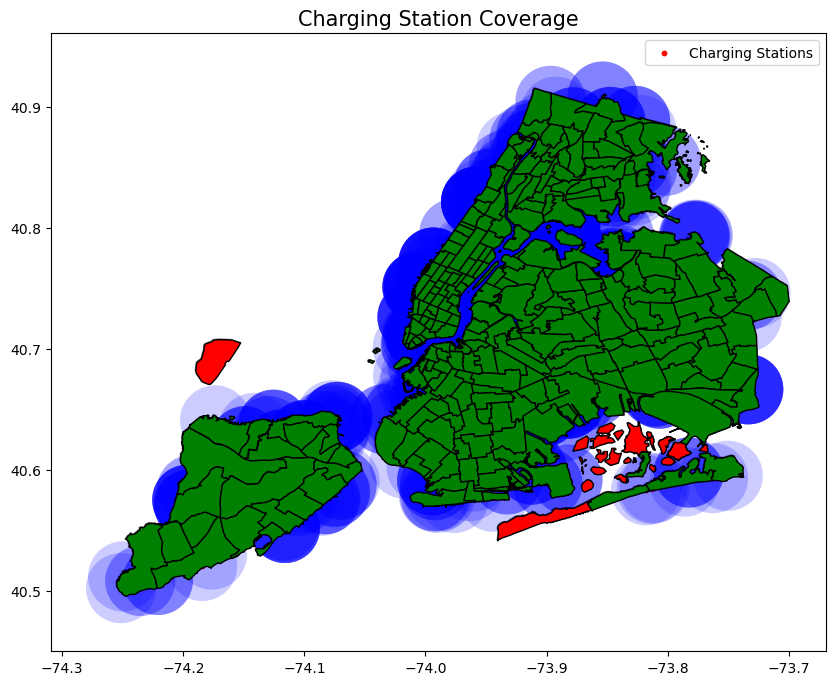

In [18]:
from shapely.geometry import Point

fig, ax = plt.subplots(figsize=(10, 10))
geo.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5, label='Zones')  # Zones in light gray
cs.plot(ax=ax, color='red', markersize=10, label='Charging Stations')  # Stations in red

# Plot the coverage areas (circles)
coverage_radius_miles = 2
for _, station in cs.iterrows():
    # Convert the radius from miles to degrees for plotting
    coverage_radius_degrees = coverage_radius_miles / 69  # Simplified conversion for plotting
    station_buffer = station['geometry'].buffer(coverage_radius_degrees)  # Buffer around station
    gpd.GeoSeries([station_buffer]).plot(ax=ax, color='blue', alpha=0.2)  # Light blue coverage area

# Highlight covered zones (those with at least one station within the radius)
for _, zone in geo.iterrows():
    zone_coords = (zone['latitude'], zone['longitude'])
    zone_covered = False
    for _, station in cs.iterrows():
        station_coords = (station['LATITUDE'], station['LONGITUDE'])
        if is_covered(zone_coords, station_coords, radius_miles=coverage_radius_miles):
            zone_covered = True
            break
    # Color the zones based on coverage
    if zone_covered:
        zone_color = 'green'
    else:
        zone_color = 'red'
    
    # Plot the zone with the appropriate color
    zone_geometry = zone['geometry']
    gpd.GeoSeries([zone_geometry]).plot(ax=ax, color=zone_color, edgecolor='black')

# Add a legend
ax.legend()

# Set the title and show the plot
ax.set_title('Charging Station Coverage', fontsize=15)
plt.show()

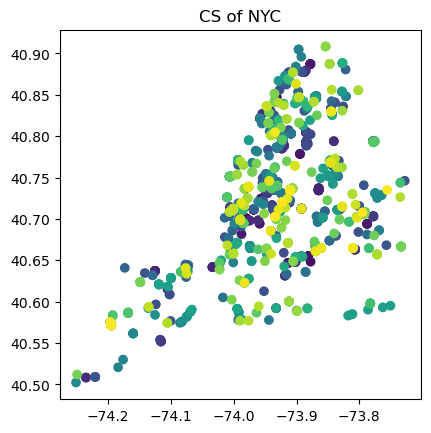

In [20]:
cs.plot(cmap='viridis')
plt.title("CS of NYC")
plt.show()